# Covid19 spreading in a networking model (part I)

## Introduction

The Covid19 has imposed a lot of pressure on epidemiologists to come up with models that can explain the impact of pandemics. There already is lot of theory developed around this topic you can check out. In particular, understanding  [SIR models](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) is really useful to understand how researchers approach the problem of virus spreading. In this notebook, I introduce some ideas about how to use Pandas, plots and graphs to explore the evolution of pandemics. I show some tools you can use to simulate networks dynamics. Of course, this cannot be considered a contribution to the state of the art. However, you may find some interesting guidelines for other problems.


## The question

The main question we ask ourselves is **has air passengers something to do with Covid19?**. If so, **can we use air traffic data to know something else about Covid19 evolution?** 

It is known that the virus started in China and later propagated around the world. If air traffic has contributed to the spread of the virus, this means that we can somehow leverage a model that explains or predict the evolution of the disease. Furthermore, we could even predict what countries could be potentially infected and/or what flights shall be cancelled.

There is a vast amount of work that can be done in this topic. To make it more accessible we will split it into smaller parts. In this first part, we will explore the data we plan to use and how to work with graphs.

## Dataset

The [OpenFlights](https://openflights.org/data.html) dataset contains airlines, air routes and airports per country. The information contained in the dataset contains information up to 2014. This may be a bit outdated. However, it is detailed enough for our purposes.

Additionally, we use the [Kraggle Covid19 challenge](https://www.kaggle.com/c/covid19-global-forecasting-week-2) data as we did in our previous Covid19 series.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import datetime

In [2]:
routes_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat'
airports_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
countries_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/countries.dat'


# Load the file with the routes
routes = pd.read_csv(routes_dataset_url, names=['Airline','AirlineID','SourceAirport', 
                                                       'SourceAirportID', 'DestinationAirport', 'DestinationAirportID',
                                                      'CodeShare','Stops','Equipment'], 
                     na_values='\\N')
display(routes)


# Load the file with the airports
airports = pd.read_csv(airports_dataset_url, names=['AirportID','Name','City','Country','IATA','ICAO',
                                                         'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
                                                         'TzDatabaseTimeZone', 'Type', 'Source'], index_col='AirportID',
                      na_values='\\N')

display(airports)

# Covid19 data
covid_data = pd.read_csv('covid19-global-forecasting-week-2/train.csv',parse_dates=['Date'], 
                   date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


Airline  AirlineID SourceAirport  SourceAirportID DestinationAirport  \
0          2B      410.0           AER           2965.0                KZN   
1          2B      410.0           ASF           2966.0                KZN   
2          2B      410.0           ASF           2966.0                MRV   
3          2B      410.0           CEK           2968.0                KZN   
4          2B      410.0           CEK           2968.0                OVB   
...       ...        ...           ...              ...                ...   
67658      ZL     4178.0           WYA           6334.0                ADL   
67659      ZM    19016.0           DME           4029.0                FRU   
67660      ZM    19016.0           FRU           2912.0                DME   
67661      ZM    19016.0           FRU           2912.0                OSS   
67662      ZM    19016.0           OSS           2913.0                FRU   

       DestinationAirportID CodeShare  Stops Equipment  
0                    2990.0       NaN      0       CR2  
1                    2990.0       NaN      0       CR2  
2                    2962.0       NaN      0       CR2  
3                    2990.0       NaN      0       CR2  
4                    4078.0       NaN      0       CR2  
...                     ...       ...    ...       ...  
67658                3341.0       NaN      0       SF3  
67659                2912.0       NaN      0       734  
67660                4029.0       NaN      0       734  
67661                2913.0       NaN      0       734  
67662                2912.0       NaN      0       734  

[67663 rows x 9 columns]

Name          City  \
AirportID                                                              
1                                       Goroka Airport        Goroka   
2                                       Madang Airport        Madang   
3                         Mount Hagen Kagamuga Airport   Mount Hagen   
4                                       Nadzab Airport        Nadzab   
5          Port Moresby Jacksons International Airport  Port Moresby   
...                                                ...           ...   
14106                              Rogachyovo Air Base        Belaya   
14107                            Ulan-Ude East Airport      Ulan Ude   
14108                             Krechevitsy Air Base      Novgorod   
14109                      Desierto de Atacama Airport       Copiapo   
14110                               Melitopol Air Base     Melitopol   

                    Country IATA  ICAO   Latitude   Longitude  Altitude  \
AirportID                                                                 
1          Papua New Guinea  GKA  AYGA  -6.081690  145.391998      5282   
2          Papua New Guinea  MAG  AYMD  -5.207080  145.789001        20   
3          Papua New Guinea  HGU  AYMH  -5.826790  144.296005      5388   
4          Papua New Guinea  LAE  AYNZ  -6.569803  146.725977       239   
5          Papua New Guinea  POM  AYPY  -9.443380  147.220001       146   
...                     ...  ...   ...        ...         ...       ...   
14106                Russia  NaN  ULDA  71.616699   52.478298       272   
14107                Russia  NaN  XIUW  51.849998  107.737999      1670   
14108                Russia  NaN  ULLK  58.625000   31.385000        85   
14109                 Chile  CPO  SCAT -27.261200  -70.779198       670   
14110               Ukraine  NaN  UKDM  46.880001   35.305000         0   

           Timezone  DST    TzDatabaseTimeZone     Type       Source  
AirportID                                                             
1              10.0    U  Pacific/Port_Moresby  airport  OurAirports  
2              10.0    U  Pacific/Port_Moresby  airport  OurAirports  
3              10.0    U  Pacific/Port_Moresby  airport  OurAirports  
4              10.0    U  Pacific/Port_Moresby  airport  OurAirports  
5              10.0    U  Pacific/Port_Moresby  airport  OurAirports  
...             ...  ...                   ...      ...          ...  
14106           NaN  NaN                   NaN  airport  OurAirports  
14107           NaN  NaN                   NaN  airport  OurAirports  
14108           NaN  NaN                   NaN  airport  OurAirports  
14109           NaN  NaN                   NaN  airport  OurAirports  
14110           NaN  NaN                   NaN  airport  OurAirports  

[7698 rows x 13 columns]

In [3]:
# We compute some intermediate dataframes that will be useful later

# Aggregate the number of flights per airport.
# Source_airport -> destination_airport, number of flights
flights_airport = routes.groupby(['SourceAirportID','DestinationAirportID']).size().reset_index(name='num_flights')

# Get the countries for the previous airport IDs
flights_country=flights_airport.join(airports.Country,on='SourceAirportID',lsuffix='Source').\
                join(airports.Country,on='DestinationAirportID',lsuffix='Destination')[['Country','CountryDestination','num_flights']]

# Aggregate the number of flights between countries
# SourceCountry -> DestinationCountry, number of flights
paths = flights_country.groupby(['Country','CountryDestination']).sum()
# Aggregate the number of flights to other countries.
paths_other_countries = flights_country[flights_country.Country != flights_country.CountryDestination].groupby(['Country','CountryDestination']).sum()

# Total number of flights per country
total_flights_country = paths.groupby(['Country']).sum()
# Total number of flights to other countries
total_flights_other_countries = paths_other_countries.groupby(['Country']).sum()


## Air routes visualization

The OpenFlights offers information about the flights between airports. Right now we are only interested in the number of flights between countries. This will simplify the visualization of the air traffic around the globle and it is enough to spot airflights hubs in the dataset.

**Note:** generating the plot may take a while. However, we added a fancy loading bar :)


In [4]:
# Some code to have a nice progress bar :)
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = 'Progress: [{0}] {1:.1f}%'.format( '#' * block + '-' * (bar_length - block), progress * 100)
    print(text)

In [5]:
fig = go.Figure()
total_rows = float(len(paths_other_countries.index))
num_row=-1
for index, row in paths_other_countries.iterrows():
    
    num_row = num_row + 1
    update_progress(num_row/total_rows)
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'country names',
            locations = index,
            mode = 'lines',
            hoverinfo= 'skip',
            line = dict(width=1,color='red'),
            opacity = float(row['num_flights'])/float(total_flights_other_countries.loc[index[0]]),
            showlegend=False,
        )
    )

fig.update_layout(
    geo = dict(
        showcountries = True,
    ),
    showlegend = False,
    title = 'Aggregated air routes between countries excluding domestic flights'
)

fig.show()

Progress: [####################] 100.0%


If the air traffic has something to do with the Covid19 spread then, China's air traffic requires our attention. The figure below shows the routes between China and other countries excluding domestic flights. The wide of every line is representative of the number of flights between countries. 

Excluding domestic flights (which are quite a few), China has connections to 62 countries. Assuming daily flights, this means that an infected passenger can propagate the disease around the globe in a few hours.

In [6]:

aux = paths_other_countries.reset_index()
aux = aux[aux.Country=='China']


fig = go.Figure()

total_rows = float(len(aux.index))
num_row=-1

the_min = aux.num_flights.min()
the_max = aux.num_flights.max()
the_mean = aux.num_flights.mean()
the_std = aux.num_flights.std()
scalator = float(the_max - the_min)

for index, row in aux.iterrows():
    num_row = num_row + 1
    update_progress(num_row/total_rows)
    width = ((float(row['num_flights'])-the_min)/scalator)*15
    #width = np.max([0.5, width])
   
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'country names',
            locations = [row.Country,row.CountryDestination],
            mode = 'lines',
            hoverinfo= 'skip',
            line = dict(width=width,color='red'),
            showlegend=False,
        )
    )
    

fig.update_layout(
    geo = dict(
        showcountries = True,
    ),
    showlegend = False,
    title = 'China aggregated air routes between countries excluding domestic flights'
)

fig.show()


Progress: [####################] 98.4%


## Disseminations with graphs

Now that we have a better understanding of our dataset and how does it look, it is time to prepare some artifacts to study the spread of the virus. In this case, we are going to translate our Pandas tables into a graph that represents the network of countries connected by their flights.

We can create a directed graph $G(V,E)$ where the set of vertices $V$ represents the countries and the set of edges $E$ represents existing air routes between countries $A$ and $B$. Additionally, we can set weights $W(E)$ with the number of flights between two countries.

There are some nice libraries to work with graphs in Python. However, I particularly like [Graph Tool](https://graph-tool.skewed.de/), maintained by [Tiago de Paula Peixoto](https://skewed.de/tiago) from the Central European University. It has implementations of some sophisticated algorithms done in C++ with OpenMP.

In [7]:
# Run this to ensure that the drawing module is correctly stablished
from graph_tool.all import *
import graph_tool as gt

In [8]:
g = gt.Graph()

# Create the country property with the country names
countries_prop = g.new_vertex_property('string')
g.vertex_properties['country'] = countries_prop

# Total number of outgoing flights per vertex
out_flights_prop = g.new_vertex_property('int')
g.vertex_properties['out_flights'] = out_flights_prop

# Create edge property with the number of flights between countries
num_flights_prop = g.new_edge_property('double')
g.edge_properties['num_flights'] = num_flights_prop

# Get the complete list of countries
list_countries = np.union1d(paths.reset_index().Country.unique(), paths.reset_index().CountryDestination.unique())

g.add_vertex(len(list_countries))

# For a given country, get the vertex
country_vertex = {}
index=0
#for c in total_flights_country.index:
for c in list_countries:
    v = g.vertex(index)
    countries_prop[v] = c
    country_vertex[c] = v
    # skip self-loops
    try: 
        out_flights_prop[v] = total_flights_other_countries.loc[c]['num_flights']
    except:
        out_flights_prop[v] = 0.0
        
    index=index+1


# Add the edges
for index,num_flights in paths.iterrows():
    s = country_vertex[index[0]]
    d = country_vertex[index[1]]
    # No self-loops
    if s != d:
        e = g.add_edge(s,d)
        num_flights_prop[e] = num_flights


We draw our graph using a radial layout with China in the center. The edges correspond to the neighbors that can be reached in a single step from China. This is, the 62 countries with direct flights from China.

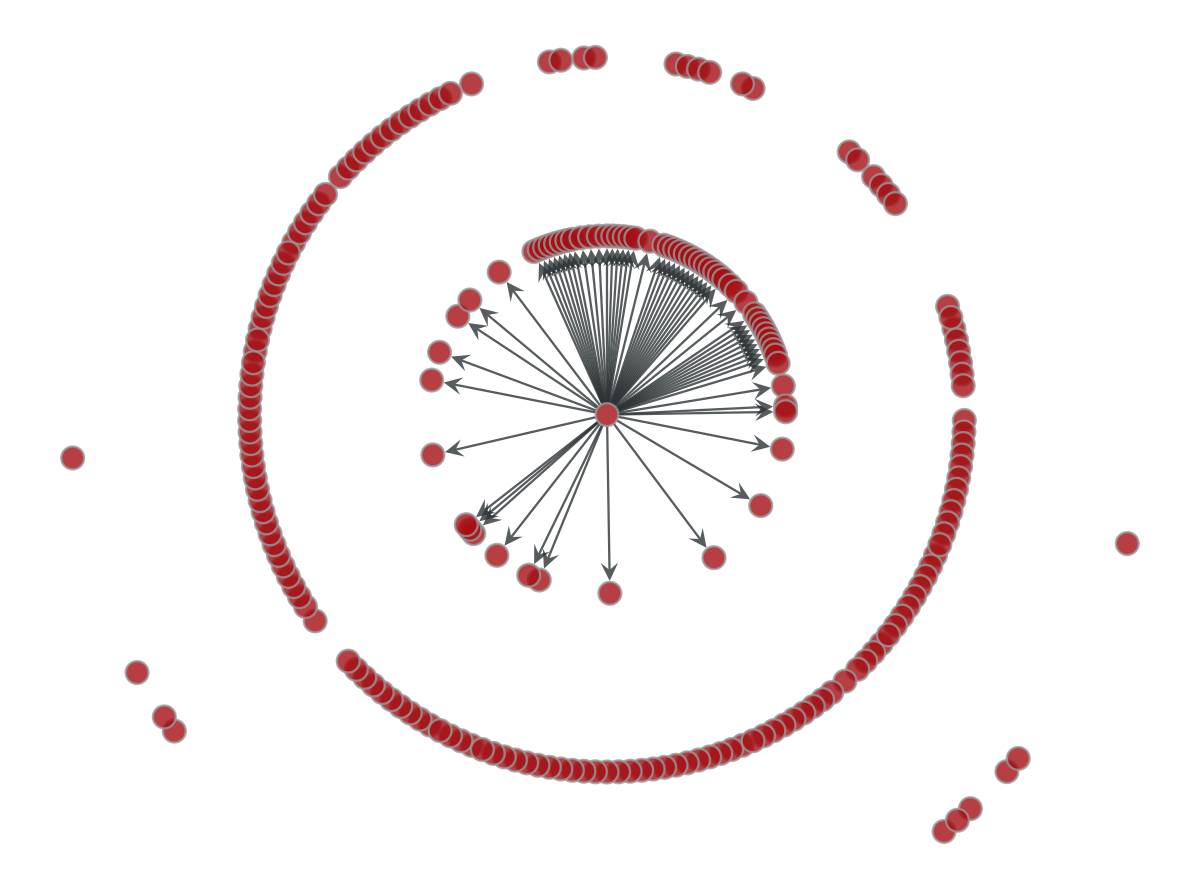

In [9]:
# plot with a radial distribution with China in the center
china_vertex = country_vertex['China']

pos = gt.draw.radial_tree_layout(g,china_vertex)
gv = gt.GraphView(g, efilt=lambda e : e.source()==china_vertex)

p=gt.draw.graph_draw(gv,pos)

Considering a dissemination scenario, we draw the edges for all the countries that can be reached after a scale in a flight from China. As you can see the number is particularly large.

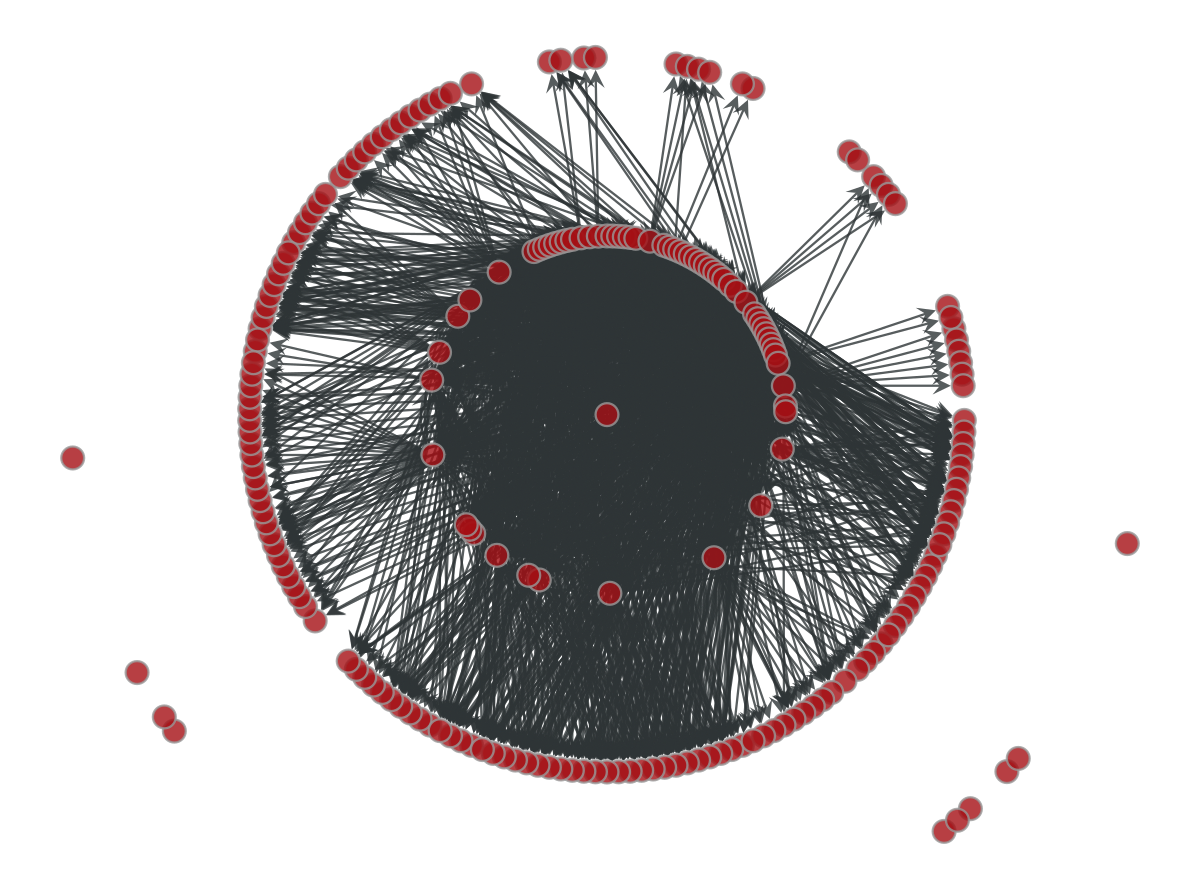

In [10]:
second_step = []
for v in g.get_out_neighbors(china_vertex):
    second_step.append(v)
    
gv2 = gt.GraphView(g, efilt=lambda e : e.target!=china_vertex and e.source() in second_step)
p=gt.draw.graph_draw(gv2,pos)

The graph above is a bit misleading. Not all the vertices will be reached from the root vertex (China) with the same probability. In other words, the frequency of flights between countries will increase the probabilities to transfer an infected passenger from China.

If we consider the weight $W$ of every edge to be the number of outgoing flights following the edge direction, everything becomes more interesting. The figure below changes the width of every edge connecting China with its flight-connected neighbors. A few number of countries (Taiwan, South Korea, Japan) accumulates most of China's outgoing traffic as the wide arrows show.

**Note:** in the figure below the $W$ weight is normalized. Otherwise, most of the connections would not be plotted.

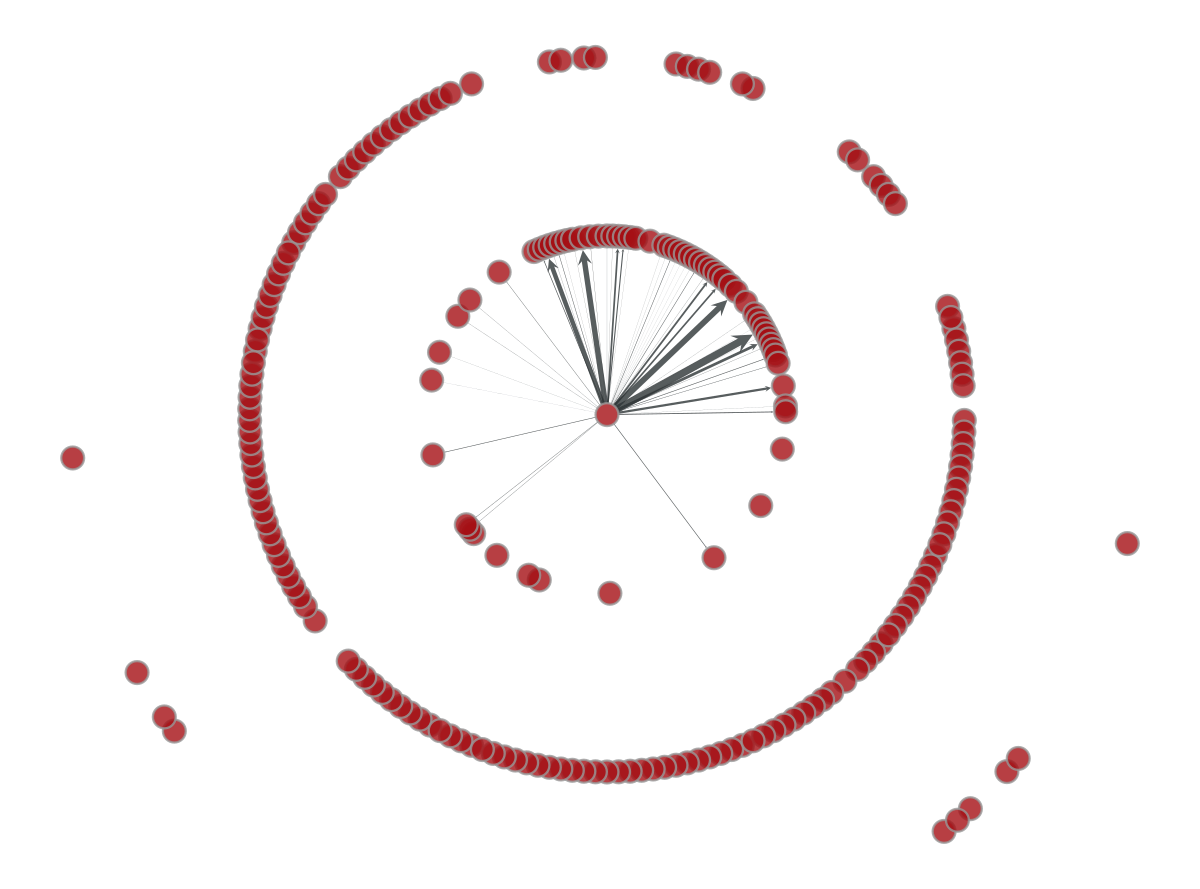

In [11]:
aux = gv.edge_properties['num_flights'].copy()

aux.a = (aux.a - aux.a.min())/(aux.a.max()-aux.a.min()) * 10
p=gt.draw.graph_draw(gv,pos,edge_pen_width=aux)


## SIR epidemic process

The [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) model is a simple, yet powerful, compartimental model for epidemics. The model consists of three compartments $S$, $I$ and $R$. $S$ is the number of susceptible, $I$ the number of infectuous and $R$ the number of recovered or deceased individuals. This is the most common model used right now and has many extensions and enhancements. The number of individuals in $S$ falls down as they become infected ($I$) and then recovered $R$. This is one of the famous infection curves used to forecast Covid19 evolution.

How to determine when a new individual moves between compartments depends on transition rates. Continuing with our initial idea about how air traffic can be an important actor in Covid19 dissemination, we can use our air flight connections graph to run a SIR simulation. 

Fortunately, graph tool comes with an implementation of the SIR model easily configurable. We run a SIR model in 63 steps which is the number of days the Covid19 required to expand worldwide in our dataset. For every edge in our graph we compute $\beta_e = \sum_{J \in out(A)} W(A,J)$ that basically sets the transition between vertices as the ratio of flights that connection represent among the total number of outgoing flights in vertex $A$. Additionally, we configure  SIR to remove spontaneous infections and reinfections and set China as the dissemination seed.


In [12]:

def runSIR(state,num_iter=100):
    '''
    For a graph tool epidemic model run the state and return a dataframe with the countries infected in every step
    '''
    infections = pd.DataFrame()
    
    previous = state.get_state().fa
    initial = np.where(previous==1)[0]
    
    for t in range(num_iter):
        ret=state.iterate_sync()
        new = state.get_state().fa
        # Find new infected countries
        diff = new - previous
        already_infected = state.get_state().fa.sum()
        non_infected = len(state.get_state().fa)-already_infected
        new_infected = [countries_prop[g.vertex(v)] for v in np.where(diff==1)[0]]
        previous = new.copy()
        # collect the results in a Pandas friendly way
        infections = infections.append([{'step':t,'norm_steps':t/float(num_iter),'infected':already_infected,
                                'new_infected': len(new_infected),'non_infected': non_infected,
                                'new_infected_countries': new_infected}], ignore_index=True)
        
    return infections


In [13]:
# Create an edge property map that can help us to define the beta probability between vertices 
beta_prop = g.new_edge_property('double')
for e in g.edges():
    beta_prop[e] = num_flights_prop[e]/out_flights_prop[e.source()]

# Assume that vertices are not susceptible, except the seed.
susceptible_prop = g.new_vertex_property('float')
for v in g.vertices():
       susceptible_prop[v] = 0.0
susceptible_prop[china_vertex]=1.0


In [14]:
state = gt.dynamics.SIRState(g, beta=beta_prop,v0 = china_vertex, constant_beta=True,gamma=0,
                              r=0,s=susceptible_prop,epsilon=0,)

infections_SIR = runSIR(state,64)
display(infections_SIR[infections_SIR.new_infected>0].head(10))

step  norm_steps infected  new_infected non_infected  \
1      1    0.015625        5             2          220   
2      2    0.031250        6             1          219   
3      3    0.046875        8             2          217   
4      4    0.062500       11             3          214   
5      5    0.078125       14             3          211   
6      6    0.093750       17             3          208   
7      7    0.109375       21             4          204   
8      8    0.125000       31            10          194   
9      9    0.140625       38             7          187   
10    10    0.156250       50            12          175   

                               new_infected_countries  
1                                [Macau, South Korea]  
2                                             [Japan]  
3                                  [Australia, India]  
4         [Malaysia, Singapore, United Arab Emirates]  
5                    [Indonesia, Laos, United States]  
6                             [Egypt, Mexico, Russia]  
7                    [Germany, Libya, Qatar, Vietnam]  
8   [Bangladesh, France, Greece, Italy, Kenya, Net...  
9   [Comoros, Iran, Moldova, Nepal, Spain, Thailan...  
10  [Austria, Cambodia, Fiji, Kazakhstan, Kuwait, ...

The output above shows the number of infected countries over time. Observe that it takes a while for the network to consider new infected countries. 

It is interesting to compare our outcomes with the current Covid19 evolution per country. We consider in our dataset that a country is infected as soon as it confirms a single case. We assume that every day after the first case appeared in China can be considered as a step in the dissemination process. This assumption is done in order to facilitate the comparison with our SIR simulation.

In [15]:
# Compute the number of infected countries
# Get the first date with confirmed cases for every country
first_date = covid_data[covid_data.ConfirmedCases > 0].groupby('Country_Region', as_index=False).Date.min().sort_values(by='Date')
# Compute the number of elapsed days since the beginning of China's outbreak
first_date['step']=first_date.Date-datetime.datetime(2020,1,22)
# Convert this column into an integer with the number of days.
first_date.step = first_date.step.dt.days
# Get the number of infected countries per region
covid_infected = first_date[['step','Country_Region']].groupby('step').agg(new_infected=('step','count'))
covid_infected['infected'] = covid_infected['new_infected'].cumsum()
covid_infected = covid_infected.reset_index()

In [16]:
f = go.Figure()
f.add_trace(
    go.Scatter(x=covid_infected.step,y=covid_infected.infected,name='Covid19')
)
f.add_trace(
    go.Scatter(x=infections_SIR.step,y=infections_SIR.infected,name='SIR')
)
f.update_layout(
    title_text='Comparing SIR infected countries evolution with original Covid19',
    xaxis=dict(title='Step'),
    yaxis=dict(title='Infected countries')
)


The original Covid19 evolution differs in the first steps with our SIR simulation. The initial plateau before the increasing slope, takes much longer in the Covid19 series. There is probably a lag between a country welcoming infected passengers and the declaration of that case. However, it is interesting to observe this difference between the number of declared cases and the evolution of our model. Obviously, there is some remaining exploration work before we can understanding why this is happening.


# Conclusions

In this notebook we have introduced some interesting tools to analyze the influence of air flights in the dissemination of the Covid19 around the world. Firstly, we have explored the OpenFlights dataset containing air traffic information around the world. Second, we have used this dataset to create an air traffic network. Finally, we have used this network to run a SIR model to understand the dissemination of the virus using air connections.


# References

Tiago P. Peixoto, “The graph-tool python library”, figshare. (2014) [DOI: 10.6084/m9.figshare.1164194](https://dx.doi.org/10.6084/m9.figshare.1164194) [sci-hub](https://sci-hub.tw/10.6084/m9.figshare.1164194)